<a href="https://colab.research.google.com/github/Ste1nb0cK/Proyecto--Simulaci-n-Gas/blob/main/Simulaci%C3%B3n_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext Cython
from numpy import linalg
import numpy as np
import random
import matplotlib.pyplot as plt

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [38]:
import glob
import moviepy.editor as mpy
from skimage.draw import *

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%cython
import numpy as np

class Particula:#En esta clase definimos los métodos fundamentales que debe seguir cada partícula

    def __init__(self, (float,float) posicion, (float,float) velocidad, float masa, float radio): 
       """comenzamos definiendo el método que debe 
        inicializar la clase, en este definimos los atributos básicos de la clase partícula
        las entradas masa y radio son de tipo float y las entradas de posición son tuplas conformadas por floats"""  
       self.radio=radio  
       self.masa=masa 
       
       self.posicion=np.array(posicion)   #Estas variables son arrays de numpy, y las trataremos como vectores
       self.velocidad=np.array(velocidad)
       self.velocidad_mag=np.linalg.norm(self.velocidad)#Este atributo no es otra cosa que la magnitud del vector velocidad
     
       """Creamos tres listas con los vectores posición y velocidad y velocidad_mag, posteriormente las usaremos
       para generar una lista con todos los valores que ha tenido la velocidad y posición"""
       
       self.velocidad_n=[self.velocidad]    ##Velocidad_n y posición_n son listas de vectores que contienen las listas correspondiente a
       self.posicion_n=[self.posicion]      ##todos los valores de estos vectores
       self.velocidad_mag_n=[self.velocidad_mag]
     
  ##########################################################################
    def paso_dt(self,float dt):   #Falta definir el valor que va a tomar dt  
       """Este método lo que hace es avanzar en el tiempo, cambia la posición de la partícula y agrega a las listas
       una actualización tanto de la posición de la partícula como la velocidad de la misma"""
      
       self.posicion=self.posicion + self.velocidad*dt  
       self.posicion_n.append(self.posicion) #Se añaden 
       self.velocidad_n.append(self.velocidad)
       self.velocidad_mag_n.append(self.velocidad_mag)
 ###############################################################################################
    def ver_colision_pp(self,otra_p):
       """Este método verifica si se dio luegar a una colisión entre dos partículas, las entradas
      son dos partículas, se definen sus radios y posiciones y se plantea una condición que indica 
      si las partículas chocaron"""
       cdef float r1=self.radio
       cdef float r2=otra_p.radio
       p1=self.posicion
       p2=otra_p.posicion
       cdef float sep=np.linalg.norm(p1-p2)#Norma del vector separación de ambas partículas.
       if sep-(r1+r2)*1.1<=0:#Si la separación es menor o igual a la suma de sus radios, entonces las partículas están en contacto y por lo tanto chocaron.
         return True
       else:
         return False
######################################################################################################
    def ver_colision_esquina(self, float Lx, float Ly):
       "Revisa si hay colisión con una esquina, Lx y Ly son las dimensiones horizontal y vertical de la caja respectivamente"
       extremo_izquierdo = self.posicion[0] - self.radio #da la posición del extremo izquido de la partícula
       extremo_inferior = self.posicion[1] - self.radio  #da la posición del extremo inferior de la partícula
       extremo_derecho  = self.posicion[0] + self.radio  #da la posición del extremo derech0 de la partícula
       extremo_superior = self.posicion[1] + self.radio  #da la posición del extremo superior de la partícula
       #Ahora construimos las variables donde se va a almacenar el hecho de chocar contra una esquina o no
       cdef bint choque_00 = extremo_izquierdo >0 and extremo_inferior> 0   #Esto corresponde a no chocar con la esquina (0,0)
       cdef bint choque_Lx0 = extremo_derecho <Lx and extremo_inferior > 0 #Esto corresponde a no chocar con la esquina (Lx,0)
       cdef bint choque_LxLy =  extremo_derecho <Lx and extremo_superior <Ly  #Esto corresponde a no chocar con la esquina (Lx,Ly)
       cdef bint choque_0Ly = extremo_izquierdo > 0 and extremo_superior <Ly  #Esto corresponde a chocar con la esquina (0,Ly)
       if not choque_00 or not choque_Lx0 or not choque_LxLy or not choque_0Ly:
         return  True 
       else:
         return False
       
        
#####################################################################################################
    def ver_colision_muro(self, float Lx, float Ly):
        """Este método revisa si la partícula ha chocado contra un muro."""
        """La condición ve que si la posición en "x" es diferente 0 o la longitud horizontal (Lx) de la caja y adicionalmente
     #  si la posición en "y" es diferente de 0 o la longitud vertical (Ly) entonces la partícula no está chocando contra un muro"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        if choque_pared_derecha and choque_pared_izquierda and choque_pared_superior and choque_pared_inferior :
          return False
        else:
          return True 
        
######################################################################################################
    def resolver_colision_particula(self,otra_p):
      """Método que actualiza las velocidades de dos partículas después de chocar
       Definimos las magnitudes a usar para resolver el choque"""
      M1=self.masa
      M2=otra_p.masa
      p1=self.posicion
      p2=otra_p.posicion
      V1=self.velocidad
      V2=otra_p.velocidad
      cdef bint choque=self.ver_colision_pp
      if choque:
        self.velocidad= self.velocidad-((2*M2)/(M1+M2))*(np.dot(p1-p2,V1-V2)/(np.linalg.norm(p1-p2)**2))*(p1-p2)#Se resuleven los choques tal cual el modelo bidimensional que se tiene
        otra_p.velocidad= otra_p.velocidad-((2*M1)/(M1+M2))*(np.dot(p2-p1,V2-V1)/(np.linalg.norm(p2-p1)**2))*(p2-p1)
  
###############################################################################################################
    def resolver_colision_muro(self,float Lx,float Ly): 
        """#Método que actualiza la velocidad después de que una partícula choca con un muro. Recibe la
        partícula y las dimensiones de la caja"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        #Ahora miramos cual fue la pared con que se chocó e invertimos la coordenada teniendo en cuenta eso
        if not choque_pared_derecha or not choque_pared_izquierda:
            self.velocidad[0] = -1* self.velocidad[0]
        elif not choque_pared_superior or not choque_pared_inferior:
            self.velocidad[1] = -1* self.velocidad[1]
       
    def resolver_colision_esquina(self):
        """Método que actualiza la velocidad después de que una partícula choca con una esquina"""
        self.velocidad = -1* self.velocidad #se invierte todo el vector
            
        

In [4]:
#Prototipo de la función final, recibe las dimensiones de la caja, el rango de velocidades inciales, el número
# de partículas, el radio y la masa
#Si algo podemos establecer por defecto que las masas y los radios sean los mismos por defecto o cómo quieran


######Función que generá las partículas con datos aleatorios
def funcion_simuladora(lx,ly,v1,v2,m,r,n):
#Por el momento se crea un arreglo vacío de enteros para las posiciones iniciales
  posiciones=np.zeros((n,2))
  
  for i in range(n):
    #Se llena el arreglo con números aleatorios dentro de la caja pero evitando que aparezcan en las esquinas
    posiciones[i][0]=np.random.uniform(10,lx-10)
    posiciones[i][1]=np.random.uniform(10,ly-10)
  #Se convierte el arreglo en una lista
  posiciones_lista=list(posiciones)
  #Las velocidades se crean normalmente con velocidades aleatorias dentro del rango establecido, el intervalo (v1,v2)
  velocidades_lista=list(np.random.uniform(v1,v2,(n,2)))
  #Ahora creamos una lista vacía donde irán objetos de la clase partícula
  lista_de_particulas=[]
  #Llenamos la lista con partículas que tendrán posiciones provenientes de posiciones_lista y velocidades_lista. 
  #Las masas y radios son los determinados al activar la función.
  for j in range(n):
    Pn=Particula(tuple(posiciones_lista[j]),tuple(velocidades_lista[j]),m,r)
    lista_de_particulas.append(Pn)
  
  
  #Ahora queremeos hacer que si las partículas se crean superpuestas de alguna manera, eliminamos una y creamos otra nueva
  #luego añadimos la nueva partícula a la lista de partículas

  for i in range(n):
   for p1 in lista_de_particulas:
    for p2 in lista_de_particulas:
     if p1.ver_colision_pp(p2):
       p_nueva=Particula(tuple([(random.uniform(10,lx-10),random.uniform(0,ly-10)) for x in range(1)][0]),
       tuple([(random.uniform(v1,v2),random.uniform(v1,v2)) for x in range(1)][0]), m,r)
                                                      
       lista_de_particulas.pop(i)
       lista_de_particulas.append(p_nueva)
  #Nos retorna la lista con las partículas creadas, acá le puse que me devolviera solo la primera para demostrar funcionalidad

  return lista_de_particulas


Simulación de 10 partículas es una caja de 100x100

[array([77.35734558, 43.18748474]), array([83.1082261 , 51.89259046]), array([88.85910662, 60.59769618]), array([94.60998713, 69.3028019 ]), array([100.36086765,  78.00790762]), array([94.60998713, 86.71301334]), array([88.85910662, 95.41811906]), array([ 83.1082261 , 104.12322478]), array([77.35734558, 95.41811906]), array([71.60646506, 86.71301334]), array([65.85558455, 78.00790762]), array([60.10470403, 69.3028019 ]), array([54.35382351, 60.59769618]), array([48.60294299, 51.89259046]), array([42.85206247, 43.18748474]), array([37.10118196, 34.48237902])]
[array([70.56694794, 83.14595795]), array([72.60201667, 91.29738095]), array([74.6370854 , 99.44880395]), array([76.67215414, 91.29738095]), array([78.70722287, 83.14595795]), array([80.7422916 , 74.99453494]), array([82.77736034, 66.84311194]), array([84.81242907, 58.69168894]), array([86.8474978 , 50.54026593]), array([88.88256653, 42.38884293]), array([90.91763527, 34.23741993]), array([92.952704  , 26.08599692]), array([94.9877

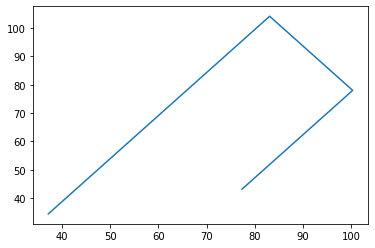

In [5]:

L=funcion_simuladora(100,100,0,100,1,1,10)#Genero 10 partículas
for n in L:#Comenzamos a iterar sobre la lista de partículas
  for j in range(15):
   
   n.paso_dt(0.1)
   if n.ver_colision_esquina(100,100):#vemos si colisionan o no con una esquina, si colisionan se resuelve la colisión
     n.resolver_colision_esquina
     #print("chcocó esquina")
   if n.ver_colision_muro(100,100):#vemos si colisionan o no con un muro, si colisionan se resuelve la colisión
     n.resolver_colision_muro(100,100)
     #print("chcocó muro")
   for p2 in L:
     if n.ver_colision_pp(p2) and (n.posicion!=p2.posicion).all():#vemos si colisionan o no con un muro, si colisionan se resuelve la colisión
       n.resolver_colision_particula(p2)                          #También se ve que la condición no haga resolver el choque de la partícula con ella
       #print("chocaron")                                         #misma

for n in range(10):#Acá vemos como se guarda cada trayectoria de cada partícula
 print(L[n].posicion_n)

x=[]
y=[]
for n in L[0].posicion_n:#graficamos la trayectoria de la primera partícula y vemos que los métodos de choque con otra partícula y con las paredes
  x.append(n[0])         #y esquinas funcionan.
  y.append(n[1])
plt.plot(x,y)
plt.show()
#plt.xlim((0,1000))
#plt.ylim((0,1000))
#En la parte de abajo del plot se ve que hay un cambio en la trayectoria, eso es porque la partícula chocó con otra

FUNCION DEFINITIVA

In [6]:
def funcion_simuladora_definitiva(lx,ly,v1,v2,m,r,n,dt,pasos):#El proceso anterior lo generalizamos en una función
  L=funcion_simuladora(lx,ly,v1,v2,m,r,n)
  for N in L:
    for i in range(pasos):
      N.paso_dt(dt)
      if N.ver_colision_esquina(lx,ly):
        N.resolver_colision_esquina
      if N.ver_colision_muro(lx,ly):
        N.resolver_colision_muro(lx,ly)
      for P in L:
        if N.ver_colision_pp(P) and (N.posicion!=P.posicion).all():
          N.resolver_colision_particula(P)
  return L
      

PRUEBA DE LA FUNCIÓN DEFINITIVA: Algo a tener en cuenta es que a la hora de extraer la información de las velcidades y posiciones a lo largo del tiempo, sí es útil que cada partícula tenga esa información, el código de la simulación no está tardando una cantidad exagerada de tiempo y me parece que es más facil manipular las cosas así.


In [7]:
A=funcion_simuladora_definitiva(100,100,0,100,1,1,10,0.01,15)
print(A[0].posicion_n)
print(A)

[array([44.06636047, 87.18604279]), array([44.53951705, 87.33426087]), array([45.01267362, 87.48247896]), array([45.4858302 , 87.63069704]), array([45.95898677, 87.77891512]), array([46.43214335, 87.92713321]), array([46.90529992, 88.07535129]), array([47.3784565 , 88.22356938]), array([47.85161307, 88.37178746]), array([48.32476965, 88.52000555]), array([48.79792622, 88.66822363]), array([49.2710828 , 88.81644172]), array([49.74423938, 88.9646598 ]), array([50.21739595, 89.11287789]), array([50.69055253, 89.26109597]), array([51.1637091 , 89.40931406])]
[<_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fde908>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fdecc0>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61ffc1d0>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fde390>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fdeb38>, <_cython_magi

DATOS PARA PATER

In [8]:
A=funcion_simuladora_definitiva(100,100,0,100,1,1,30,0.01,50)
print(A)
L=[]#Esta lista está formada por 30 sublistas que tienen el recorrido de la partículas, por alguna razón no me dejó separar esas sublistas
     #En una tupla de listas para x e y pero esto es lo que se tiene, si Pater puede mirar la forma de correrlo así le agradezco
for n in A:
  L.append(n.posicion_n)
print(L)

[<_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fde748>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fdeb00>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fde5f8>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fde860>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fde7b8>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fdebe0>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fdee80>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fdec18>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fde2e8>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fde940>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f0a61fdea58>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object

PRUEBA PARA MUCHAS PARTÍCULAS

In [9]:
funcion_simuladora_definitiva(1000,1000,0,100,1,1,150,0.01,1500)#se demora entre 5 y 10 minutos (1500 pasos, con 150 partículas)

###Animación de las partículas 

In [42]:
##La funcion Organizar me permite recibir las listas que me da mateo y las convierte a las caracteristicas necesarias para ListaOf
def Organizar(lista):
  L=[]
  lx=[]
  ly=[]
  LOf=[]
  for x in range(0,len(lista)):
    for c in range(0,len(lista[x])):
      lx.append(int(lista[x][c][0]))
      ly.append(int(lista[x][c][1]))
      L.append(lx)
      L.append(ly)
    LOf.append(np.copy(L))
    L.clear()
  return LOf

#Definimos la ListaOf que utilizaremos para correr la animacion 
ListaOf=Organizar(L)

#Definimos la caja que necesitamos para correr la aniamcion 
BoxOf=np.zeros((110,110))

In [43]:
########Creación de las imagenes########
#En principio este codigo funciona para n particulas pero debe estar definida la lista ListaOf con anterioridad

#En Gif se guardaran cada una de las imagenes 
Gif=[]
#Recuerde que debe cambiar la informacion del radio dependiendo de la simulacion creada, la cual corresponde al ultimo valor en la funcion circulo
for x in range(0,len(ListaOf[0][1])):
  for i in range(0,len(ListaOf)):
    x1,y1=circle(ListaOf[i][0][x],ListaOf[i][1][x],1)
    BoxOf[x1,y1]=255
  Gif.append(np.copy(BoxOf))
  BoxOf=np.zeros((20,15))

IndexError: ignored

In [ ]:
########Descarga de las imagenes########
#Con esto descarga cada una de las imagenes, el archivo descomprime las imagenes en drive, por lo cual recuerde cambiar la ruta
#Las imagenes se guardan en formato png y se guardan en orden cuando son menos de 10000 imagenes

for x in range(0,len(Gif)):
  if x<10:
    plt.imshow(Gif[x])
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/Proyecto /GifMateo/img000{0}.png".format(x), bbox_inches='tight') 
  elif x<100:
    plt.imshow(Gif[x])
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/Proyecto /GifMateo/img00{0}.png".format(x), bbox_inches='tight') 
  elif x<1000:
    plt.imshow(Gif[x])
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/Proyecto /GifMateo/img0{0}.png".format(x), bbox_inches='tight') 
  elif x<10000:
    plt.imshow(Gif[x])
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/Proyecto /GifMateo/img{0}.png".format(x), bbox_inches='tight') 

In [ ]:
########Creación del Gif########

#GifOfFinal es una lista donde sus elementos son las imagenes, estoy usando una libreria que manipula documentos, por lo cual se debe cambiar la ruta 
GifOfFinal = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/Proyecto /GifMateo/*.png'))  
GifOfFinal.sort() 

#Dependiendo del numero de imagenes cambio el valor de la variable fps
fps = 5
clip = mpy.ImageSequenceClip(GifOfFinal, fps=fps)
clip.write_gif('movieMateo.gif')

#El gif se guarda dentro de la consola asi que debe descargarlo 

In [40]:
####Con esto puede comprobar la informacion dentro de las listas###
print("Orden de las listas")
print("Numero de particulas")
print(len(L))
print("Numero de pasos de la particula n")
print(len(L[0]))
print("Particula n")
print(L[0])
print("N-esima tupla de la particula n")
print(L[0][0])
print("radio x")
print(int(L[0][0][0]))
print("radio y")
print(int(L[0][0][1]))
print("Pruebas ListaOf")
print(ListaOf)
print("N-esima particula")
print(ListaOf[0])
print("Datos x")
print(ListaOf[0][0])
print("Datos y")
print(ListaOf[0][1])

Orden de las listas
Numero de particulas
30
Numero de pasos de la particula n
51
Particula n
[array([66.56154633, 35.97829056]), array([67.24203459, 36.76176611]), array([67.92252286, 37.54524166]), array([68.60301112, 38.32871722]), array([69.28349939, 39.11219277]), array([69.96398766, 39.89566832]), array([70.64447592, 40.67914388]), array([71.32496419, 41.46261943]), array([72.00545245, 42.24609498]), array([72.68594072, 43.02957054]), array([73.36642899, 43.81304609]), array([74.04691725, 44.59652164]), array([74.72740552, 45.3799972 ]), array([75.40789378, 46.16347275]), array([76.08838205, 46.9469483 ]), array([76.76887032, 47.73042386]), array([77.44935858, 48.51389941]), array([78.12984685, 49.29737496]), array([78.81033511, 50.08085051]), array([79.49082338, 50.86432607]), array([80.17131165, 51.64780162]), array([80.85179991, 52.43127717]), array([81.53228818, 53.21475273]), array([82.21277644, 53.99822828]), array([82.89326471, 54.78170383]), array([83.57375298, 55.56517939